Let $X$ be a sample of size $\mathrm{n}$, and you want to test if it follows standard normal distribution $N(0,1)$. You split the real line into the regions:
$$
(-\infty ;-2),(-2,-1.5),(-1.5,-1),(-1,-0.5),(-0.5,0.5),(0.5,1),(1,1.5),(1.5,2),(2, \infty)
$$
Let $O_k$ be the number of observations from $X$ in the $k$-th region; $p_k$ be the probability that the standard normal variable was in the $k$-th region.
- Write a function which computes the chi-squared statistics:
$$
\sum_{k=1}^9 \frac{\left(O_k-n \cdot p_k\right)^2}{n \cdot p_k}
$$
How is the statistics distributed if null hypothesis holds? Provide a histogram and the mean value of this distribution.
- What is the p-value? Can you reject the null-hypothesis?
- As in HW4 plot, how $\alpha_I$ depends on confidence level $\alpha$ for this case. Show, how this plot changes, when we alter number of breaks that were chosen in 1 (the begining of task). What happends, when the number of breaks is 3 ?

In [1]:
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt
from numpy import arange
from tqdm.notebook import trange, tqdm

Here is the code to create the regions and to get the chi2 statistics for our sample

In [2]:
regions = [(-1e10, -2), 
           (-2, -1.5),
           (-1.5, -1),
           (-1, -0.5),
           (-0.5, 0.5),
           (0.5, 1),
           (1, 1.5),
           (1.5, 2),
           (2, 1e10)]

In [3]:
def get_proba_region(region):
    return norm.cdf(region[1]) - norm.cdf(region[0])
    
def get_chi2_stats(sample, regions):
    observed_counts = [0 for i in range(len(regions))]
    for element in sample:
        for i, region in enumerate(regions):
            if region[0] < element < region[1]:
                observed_counts[i] += 1
                break
    chi2_stats = 0
    n = len(sample)
    for i in range(len(regions)):
        estimated_count = n * get_proba_region(regions[i])
        chi2_stats += (observed_counts[i] - estimated_count) ** 2 / estimated_count
    return chi2_stats, observed_counts

In [4]:
sample = norm.rvs(size=1000)
chi2_stats, observed_counts = get_chi2_stats(sample, regions)

In [5]:
observed_counts

[27, 44, 90, 135, 393, 156, 97, 45, 13]

In [6]:
chi2_stats

7.3114833600605404

If the null hypothesis is correct our statistics should be distributed as Chi2 with 8 degrees of freedom. Let's see how this distribution looks like.

chi2 mean is:  8.0


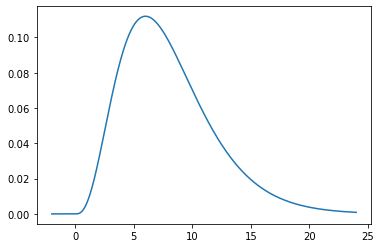

In [7]:
xs = [i for i in arange(-2, 24, 0.01)]
ys = [chi2.pdf(x, 8) for x in xs]
print(f'chi2 mean is: ', chi2.stats(8, moments='m'))
plt.plot(xs, ys)

P-value can be calculated as 2min(P(t<x), P(t>x)). So we can calculate it using the CDF.

In [8]:
left_sided_proba = chi2.cdf(chi2_stats, df=8)
right_sided_proba = 1 - chi2.cdf(chi2_stats, df=8)

In [9]:
2*min(left_sided_proba, right_sided_proba)

0.9931420804183638

We got the value more than 0.05 which means we cannot reject the null hypothesis

Now let's plot the first type error probability plot.

In [10]:
def generate_first_type_error_for_alpha(alpha, regions):
    left = chi2.ppf((1 - alpha) / 2, df=len(regions)-1)
    right = chi2.ppf(1 - (1 - alpha) / 2, df=len(regions)-1)
    results = [0 if left < get_chi2_stats(norm.rvs(size=100), regions)[0] < right else 1 for i in range(200)]
    return sum(results) / len(results)

In [11]:
alphas = []
first_type_errors = []
for alpha in tqdm(arange(0, 1, 0.01)):
    alphas.append(alpha)
    first_type_errors.append(generate_first_type_error_for_alpha(alpha, regions))

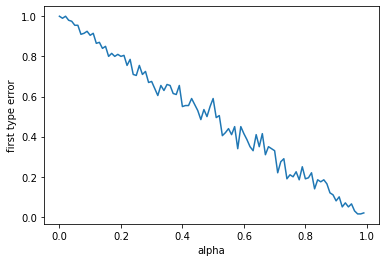

In [12]:
plt.plot(alphas, first_type_errors)
plt.xlabel("alpha")
plt.ylabel("first type error")
plt.show()

In [13]:
def generate_regions_for_number_of_breaks(number_of_regions=9):
    piece_area = 1 / number_of_regions
    regions = []
    used_proba = 0
    cur_start = -1e10
    for i in range(number_of_regions):
        used_proba += piece_area
        cur_end = norm.ppf(used_proba)
        regions.append((cur_start, cur_end))
        cur_start = cur_end
    regions[-1] = (regions[-1][0], 1e10)
    return regions

In [14]:
generate_regions_for_number_of_breaks()

[(-10000000000.0, -1.22064034884735),
 (-1.22064034884735, -0.7647096737863871),
 (-0.7647096737863871, -0.43072729929545756),
 (-0.43072729929545756, -0.13971029888186212),
 (-0.13971029888186212, 0.13971029888186212),
 (0.13971029888186212, 0.4307272992954577),
 (0.4307272992954577, 0.7647096737863875),
 (0.7647096737863875, 1.220640348847351),
 (1.220640348847351, 10000000000.0)]

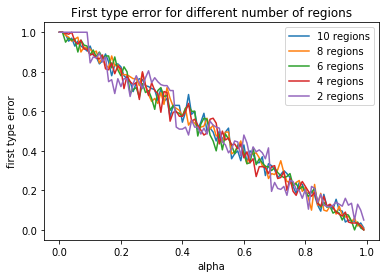

In [15]:
for breaks in tqdm(range(10, 1, -2)):
    regions = generate_regions_for_number_of_breaks(number_of_regions=breaks)
    alphas = []
    first_type_errors = []
    for alpha in arange(0, 1, 0.01):
        alphas.append(alpha)
        first_type_errors.append(generate_first_type_error_for_alpha(alpha, regions))
    plt.plot(alphas, first_type_errors, label=f"{breaks} regions")
plt.title(f'First type error for different number of regions')
plt.xlabel("alpha")
plt.ylabel("first type error")
plt.legend()
plt.show()

We can actually see here that the plots are almost the same (except for the plot for 2 regions which looks more robust than the others).

Let's evaluate the second type error taking the sample from N(0, 1.75)

In [24]:
def generate_second_type_error_for_alpha(alpha, regions):
    left = chi2.ppf((1 - alpha) / 2, df=len(regions)-1)
    right = chi2.ppf(1 - (1 - alpha) / 2, df=len(regions)-1)
    results = [1 if left < get_chi2_stats(norm.rvs(loc=0, scale=1.75, size=100), regions)[0] < right else 0 for i in range(100)]
    return sum(results) / len(results)

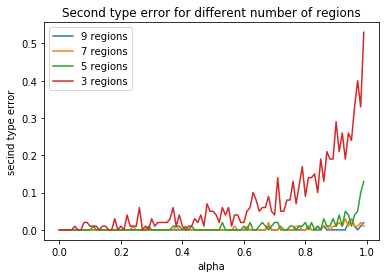

In [25]:
for breaks in tqdm(range(9, 1, -2)):
    regions = generate_regions_for_number_of_breaks(number_of_regions=breaks)
    alphas = []
    second_type_errors = []
    for alpha in arange(0, 1, 0.01):
        alphas.append(alpha)
        second_type_errors.append(generate_second_type_error_for_alpha(alpha, regions))
    plt.plot(alphas, second_type_errors, label=f"{breaks} regions")
plt.title(f'Second type error for different number of regions')
plt.xlabel("alpha")
plt.ylabel("secind type error")
plt.legend()
plt.show()

For the second type error we can see that the less regions we take the less chances to catch the second type error is.
This is most obvious for regions count equal to three when the plot goes up very strongly making our criteria not powerful.